Fonction pour merge les fichiers parquet de HF

Merge les données

Création du DS HF

In [1]:
from datasets import load_dataset
ds = load_dataset("parquet", data_files="data/mmimdb_merged.parquet", split="train")


C:\Users\Utilisateur\OneDrive - Groupe ESAIP\Bureau\Cetic_code\pythonProject1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def flatten_text_only(example):

    import json
    msgs = example.get("messages", []) or []

    user_msgs = [m.get("content", "") for m in msgs if m.get("role") == "user"]
    assistant_msgs = [m.get("content", "") for m in msgs if m.get("role") == "assistant"]

    prompt = "\n\n".join([u for u in user_msgs if isinstance(u, str)]) if user_msgs else ""
    answer = assistant_msgs[-1] if assistant_msgs else ""

    return {
        "prompt": prompt,
        "answer": answer,
    }


In [4]:
print(ds)
ds_flat = ds.map(flatten_text_only, remove_columns=ds.column_names)
df = ds_flat.to_pandas()

Dataset({
    features: ['messages', 'images'],
    num_rows: 15552
})


Map: 100%|██████████| 15552/15552 [00:00<00:00, 18819.21 examples/s]


In [5]:
print(ds_flat[0])
print(df.count().isnull())

{'prompt': 'Given the movie poster and the corresponding plot of the movie, choose the appropriategenres from the following comma separated genres: drama, comedy, romance, thriller, crime, action, adventure,horror, documentry, mystery, sci-fi, fantasy, family, biography, war, history, music, animation, musical,western, sport, short, film-noir.\nPlot: Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.\nNote that a movie can belong to more than one genres,provide all the suitable genres separated by commas. Answer:', 'answer': 'Crime, Drama, Thriller'}
prompt    False
answer    False
dtype: bool


In [6]:
print(ds_flat)

Dataset({
    features: ['prompt', 'answer'],
    num_rows: 15552
})


In [7]:
print(ds_flat[0]['prompt'])

Given the movie poster and the corresponding plot of the movie, choose the appropriategenres from the following comma separated genres: drama, comedy, romance, thriller, crime, action, adventure,horror, documentry, mystery, sci-fi, fantasy, family, biography, war, history, music, animation, musical,western, sport, short, film-noir.
Plot: Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.
Note that a movie can belong to more than one genres,provide all the suitable genres separated by commas. Answer:


In [8]:
#Garde seulement le prompt ce qui permet d'optimiser l'entrainement aussi bien en temps qu'en perf
import re

# Ne garde que le texte du plot
PATTERN = re.compile(r'(?is)\bplot\s*:\s*(.*?)(?=\bnote\s+that\b|answer\s*:|$)')

def extract_plot(text: str) -> str:
    if text is None:
        return None
    m = PATTERN.search(text)
    if not m:
        return ""  # ou text.strip() si tu préfères conserver l'original quand Pas de "Plot:"
    plot = m.group(1).strip()
    # petites normalisations
    plot = re.sub(r'\s+\n', '\n', plot)
    plot = re.sub(r'\s{2,}', ' ', plot)
    return plot

# Option A : créer une colonne 'plot'
ds_flat = ds_flat.map(lambda batch: {"plot": [extract_plot(t) for t in batch["prompt"]]},
                      batched=True)

# Option B : remplacer 'prompt' par le seul plot
# ds_flat = ds_flat.map(lambda batch: {"prompt": [extract_plot(t) for t in batch["prompt"]]},
#                       batched=True)


Map: 100%|██████████| 15552/15552 [00:00<00:00, 22082.53 examples/s]


In [9]:
print(ds_flat[0]['plot'])


Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.


Partie en ds

In [10]:
import re
from datasets import Features, Sequence, Value

LABELS = [
    "drama","comedy","romance","thriller","crime","action","adventure","horror",
    "documentary","mystery","sci-fi","fantasy","family","biography","war","history",
    "music","animation","musical","western","sport","short","film-noir"
]
label2id = {lab:i for i,lab in enumerate(LABELS)}

ALIASES = {
    "documentry": "documentary",
    "science fiction": "sci-fi",
    "sci fi": "sci-fi",
    "film noir": "film-noir",
    "westerns": "western",
    "sports": "sport",
}

def norm_token(t: str) -> str:
    t = t.lower()
    t = re.sub(r"[\s\-]+", " ", t).strip()
    t = ALIASES.get(t, t)
    t = t.replace("sci fi", "sci-fi")
    return t

def parse_answer(ans: str):
    if ans is None:
        return set()
    toks = re.split(r"[;,]", ans)
    toks = [norm_token(x) for x in toks if x.strip()]
    return set(t for t in toks if t in label2id)

def to_multi_hot_float(labels_set):
    vec = [0.0]*len(LABELS)
    for lab in labels_set:
        vec[label2id[lab]] = 1.0
    return vec

def mapper(batch):
    answers = batch["answer"]
    return {"labels": [to_multi_hot_float(parse_answer(a)) for a in answers]}

new_features = ds_flat.features.copy()
new_features["labels"] = Sequence(feature=Value("float32"), length=len(LABELS))

ds_flat = ds_flat.map(mapper, batched=True, features=new_features)
print(type(ds_flat[0]["labels"][0]), ds_flat.features["labels"])
# -> <class 'float'> Sequence(feature=Value(dtype='float32', id=None), length=23, id=None)


Map: 100%|██████████| 15552/15552 [00:00<00:00, 70392.93 examples/s]

<class 'float'> List(Value('float32'), length=23)


In [11]:
print(ds_flat[0]["labels"])

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
from transformers import AutoTokenizer

# Définition du tokenizer
model_name = "bert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(model_name) 

def tokenize_and_count(example):
    # Tokenisation sans padding ni truncation
    plot_tokens = tokenizer(example['plot'], add_special_tokens=False)['input_ids']

    # Comptage
    num_title_tokens = len(plot_tokens)
    total_tokens = num_title_tokens

    # Retour sous forme de colonnes
    return {
        "num_title_tokens": num_title_tokens,
        "num_tokens_total": total_tokens
    }

# Application sur tout le dataset (batched=False car une instance à la fois)
countTokenize = ds_flat.map(tokenize_and_count)

# Vérification
print(countTokenize['plot'][0])

C:\Users\Utilisateur\OneDrive - Groupe ESAIP\Bureau\Cetic_code\pythonProject1\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Utilisateur\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 15552/15552 [00:04<00:00, 3209.86 exampl

Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.


In [13]:
print(countTokenize[0])

{'prompt': 'Given the movie poster and the corresponding plot of the movie, choose the appropriategenres from the following comma separated genres: drama, comedy, romance, thriller, crime, action, adventure,horror, documentry, mystery, sci-fi, fantasy, family, biography, war, history, music, animation, musical,western, sport, short, film-noir.\nPlot: Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.\nNote that a movie can belong to more than one genres,provide all the suitable genres separated by commas. Answer:', 'answer': 'Crime, Drama, Thriller', 'plot': 'Mild mannered businessman Anthony Wongs life is shattered when his pregnant wife is run over by a busy taxi driver. This and another incident with a sleazy cab driver causes Wong to go on a mission to kill bad taxi drivers.', 'labels': [1.0, 0.0, 0.0, 1.0, 1.0,

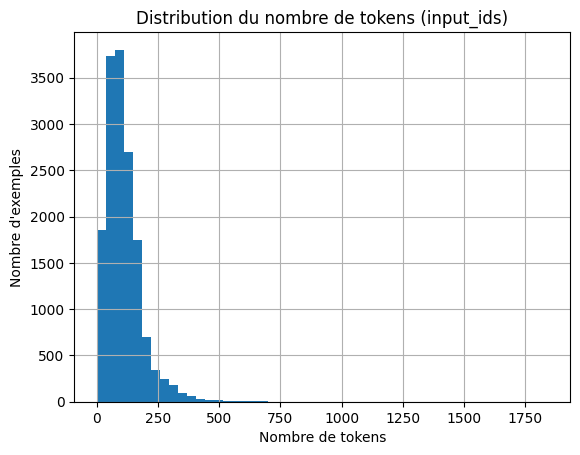

In [14]:
import matplotlib.pyplot as plt

token_counts = countTokenize["num_tokens_total"]  # ou "validation", "test" selon le cas

plt.hist(token_counts, bins=50)
plt.title("Distribution du nombre de tokens (input_ids)")
plt.xlabel("Nombre de tokens")
plt.ylabel("Nombre d'exemples")
plt.grid(True)
plt.show()

In [15]:
import numpy as np

token_counts = countTokenize["num_tokens_total"] # ou autre split

percentile_90 = int(np.percentile(token_counts, 90))
print(f"90% des exemples ont une longueur ≤ {percentile_90} tokens")

90% des exemples ont une longueur ≤ 191 tokens


In [16]:
MAX_LEN = 224
print(MAX_LEN)

224


In [17]:
# Tokenisation sans padding ni truncation

def tokenize_function(examples):
    return tokenizer(examples["plot"],
                     padding="max_length",
                     truncation=True )

tokenized_datasets = ds_flat.map(tokenize_function, batched=True)

tokenizer.save_pretrained("../dataset/mon_tokenizer")

Map: 100%|██████████| 15552/15552 [00:03<00:00, 4770.77 examples/s]


('../dataset/mon_tokenizer\\tokenizer_config.json',
 '../dataset/mon_tokenizer\\special_tokens_map.json',
 '../dataset/mon_tokenizer\\vocab.txt',
 '../dataset/mon_tokenizer\\added_tokens.json',
 '../dataset/mon_tokenizer\\tokenizer.json')

In [18]:
from datasets import DatasetDict

# Split à 90% train / 20% test
dataset = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

train_dataset = dataset["train"].shuffle(seed=42)
eval_dataset = dataset["test"].shuffle(seed=42)

In [19]:
import numpy as np

# Convertir tous les labels en tableau numpy (n_samples, 6)
label_array = np.array(train_dataset['labels'])

# Somme par colonne (i.e., par classe)
label_sums = label_array.sum(axis=0)

# Affichage
print("Répartition multilabel dans train_dataset :")
for idx, count in enumerate(label_sums):
    print(f"Label {idx}: {int(count)} occurrences")

Répartition multilabel dans train_dataset :
Label 0: 6710 occurrences
Label 1: 4081 occurrences
Label 2: 2589 occurrences
Label 3: 2465 occurrences
Label 4: 1824 occurrences
Label 5: 1688 occurrences
Label 6: 1284 occurrences
Label 7: 1272 occurrences
Label 8: 998 occurrences
Label 9: 972 occurrences
Label 10: 959 occurrences
Label 11: 948 occurrences
Label 12: 790 occurrences
Label 13: 631 occurrences
Label 14: 655 occurrences
Label 15: 548 occurrences
Label 16: 514 occurrences
Label 17: 463 occurrences
Label 18: 408 occurrences
Label 19: 341 occurrences
Label 20: 301 occurrences
Label 21: 225 occurrences
Label 22: 159 occurrences


In [20]:
import numpy as np

# Convertir tous les labels en tableau numpy (n_samples, 6)
label_array = np.array(eval_dataset['labels'])

# Somme par colonne (i.e., par classe)
label_sums = label_array.sum(axis=0)

# Affichage
print("Répartition multilabel dans train_dataset :")
for idx, count in enumerate(label_sums):
    print(f"Label {idx}: {int(count)} occurrences")

Répartition multilabel dans train_dataset :
Label 0: 1714 occurrences
Label 1: 1027 occurrences
Label 2: 637 occurrences
Label 3: 648 occurrences
Label 4: 469 occurrences
Label 5: 467 occurrences
Label 6: 327 occurrences
Label 7: 331 occurrences
Label 8: 236 occurrences
Label 9: 259 occurrences
Label 10: 253 occurrences
Label 11: 214 occurrences
Label 12: 188 occurrences
Label 13: 157 occurrences
Label 14: 151 occurrences
Label 15: 132 occurrences
Label 16: 120 occurrences
Label 17: 123 occurrences
Label 18: 95 occurrences
Label 19: 82 occurrences
Label 20: 78 occurrences
Label 21: 56 occurrences
Label 22: 43 occurrences


In [23]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import torch

def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids

    # Convert logits to probabilities via sigmoid
    probs = torch.sigmoid(torch.from_numpy(logits)).numpy()

    # Binarisation avec seuil 0.5
    preds = (probs > 0.4).astype(int)

    # Retourne les métriques arrondies à 4 décimales
    return {
        "exact_match_accuracy": round(accuracy_score(labels, preds), 2),
        "label_accuracy": round((preds == labels).mean(), 2),
        "f1_micro": round(f1_score(labels, preds, average="micro", zero_division=0), 2),
        "f1_macro": round(f1_score(labels, preds, average="macro", zero_division=0), 2),
        "precision_micro": round(precision_score(labels, preds, average="micro", zero_division=0), 2),
        "recall_micro": round(recall_score(labels, preds, average="micro", zero_division=0), 2),
    }

In [24]:

from transformers import BertConfig, BertForSequenceClassification
N_LABELS = 23
config = BertConfig.from_pretrained('bert-base-uncased')
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3
config.classifier_dropout = 0.3
config.num_labels = N_LABELS
config.problem_type = "multi_label_classification"

# Initialiser le modèle avec cette configuration
from transformers import BertForSequenceClassification, BertConfig

# Crée une config avec 6 labels et le bon type de problème
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=N_LABELS,
    problem_type="multi_label_classification"
)

# Charge le modèle avec cette config
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=config
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    report_to="wandb",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

C:\Users\Utilisateur\OneDrive - Groupe ESAIP\Bureau\Cetic_code\pythonProject1\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\Utilisateur\OneDrive - Groupe ESAIP\Bureau\Cetic_code\pythonProject1\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model f

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import json
# --- Sauvegarde tête seule ---
head_path = "data/classifier_head.pt"
meta_path = "data/classifier_head_meta.json"

torch.save(model.classifier.state_dict(), head_path)

meta = {
    "num_labels": model.config.num_labels,
    "hidden_size": model.config.hidden_size,
    "classifier_type": type(model.classifier).__name__,  # "BertOnlyMLMHead" ? non, ici typiquement "Linear"
    "dropout_in_config": getattr(model.config, "classifier_dropout", None),
}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

Etude effectuer

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

In [ ]:
import torch
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_multilabel(text, model, tokenizer, threshold=0.5, label_names=None):
    model.eval()

    device = next(model.parameters()).device  # récupère le device du modèle
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # shape: [1, num_labels]

    probs = sigmoid(logits.cpu().numpy())[0]  # passage sur CPU pour numpy + sigmoid
    predictions = (probs >= threshold).astype(int)

    # indices triés par proba décroissante
    order = np.argsort(-probs)

    results = {}
    for i in order:
        label = label_names[i] if label_names else f"label_{i}"
        results[label] = {
            "score": float(probs[i]),
            "predicted": bool(predictions[i])
        }

    return results

In [ ]:
from IPython.display import display

img = eval_dataset["images_json"][0]   # retourne un objet PIL.Image.Image
display(img)                     # ou juste `img` en notebook

In [ ]:
print(eval_dataset[a]['labels'])
print(eval_dataset[a]['answer'])


In [ ]:
import torch
import numpy as np
import random
a=random.randint(0, 3110)
print(eval_dataset[a]['plot'])
print("resultat = " +eval_dataset[a]['answer'])
text = eval_dataset[a]['plot']
label_names = LABELS

results = predict_multilabel(text, model, tokenizer, threshold=0.5, label_names=label_names)

for label, info in results.items():
    print(f"{label:10} | score: {info['score']:.4f} | prédiction: {'✔️' if info['predicted'] else '❌'}")


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

pred = trainer.predict(eval_dataset)
logits = pred.predictions               # shape (n_samples, n_labels)
y_true = pred.label_ids                 # 0/1

y_prob = 1/(1+np.exp(-logits))          # sigmoïde
y_pred = (y_prob >= 0.5).astype(int)

ml_cm = multilabel_confusion_matrix(y_true, y_pred)  # (n_labels, 2, 2)


In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# y_true: array (n_samples, n_labels) de 0/1
# y_prob: array (n_samples, n_labels) de proba dans [0,1] (ou logits après sigmoid)
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

ml_cm = multilabel_confusion_matrix(y_true, y_pred)  # shape: (n_labels, 2, 2)
# ml_cm[i] = [[TN, FP],
#             [FN, TP]] pour le label i

# Afficher une matrice pour un label donné (ex: i=0)
import matplotlib.pyplot as plt

i = 0  # index du label à visualiser
fig, ax = plt.subplots()
im = ax.imshow(ml_cm[i], cmap="Blues")
ax.set_xticks([0,1]); ax.set_xticklabels(["Négatif", "Positif"])
ax.set_yticks([0,1]); ax.set_yticklabels(["Négatif", "Positif"])
ax.set_xlabel("Prédit"); ax.set_ylabel("Vrai")
for (r,c), val in np.ndenumerate(ml_cm[i]):
    ax.text(c, r, int(val), ha="center", va="center")
plt.title("Matrice de confusion — label %d" % i)
plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

# Rapport utile par label (precision/recall/F1 micro/macro)
print(classification_report(y_true, y_pred, target_names=label_names))


In [ ]:
zaeae

In [ ]:
# Supprimer les textes inutiles
s = df['prompt'].astype(str).str.replace('\u00A0', ' ', regex=False)

# coupe tout ce qui est avant "Plot:" (insensible à la casse) ET enlève "Plot:"
df['plot_text'] = s.str.replace(r'(?is)^.*?plot\s*:\s*', '', regex=True).str.strip()


In [ ]:
print(df['plot_text'][0])

In [ ]:
# supprime "Note..." et tout ce qui suit
df['plot_only'] = (df['plot_text']
                   .str.replace(r'(?is)\bnote\b.*$', '', regex=True)
                   .str.strip(" \n\r\t:."))  # nettoie la fin

In [ ]:

print(df['plot_only'][0])

In [ ]:
df = df.drop('plot_text', axis=1)
print(df.iloc[0])

etudie l'équilibre du dataset

In [ ]:
import re
import pandas as pd
from collections import Counter
from itertools import combinations

# ===== 1) Paramètres =====
ANSWER_COL = "answer"  # <-- adapte au nom réel de ta colonne

ALLOWED = [
    "drama","comedy","romance","thriller","crime","action","adventure","horror",
    "documentary","mystery","sci-fi","fantasy","family","biography","war","history",
    "music","animation","musical","western","sport","short","film-noir"
]

# ===== 2) Normalisation / parsing =====
def normalize_label(lbl: str) -> str:
    x = lbl.strip().lower()
    x = re.sub(r"\s+", " ", x)
    x = x.replace("documentry","documentary")
    x = x.replace("scifi","sci-fi").replace("sci fi","sci-fi")
    x = x.replace("film noir","film-noir")
    return x

def parse_answer_to_labels(s: str):
    if pd.isna(s):
        return []
    s = re.sub(r"(?i)^answer\s*:\s*", "", str(s).strip())
    parts = [normalize_label(p) for p in s.split(",")]
    # supprimer vides et doublons en gardant l'ordre
    seen, out = set(), []
    for p in parts:
        if p and p not in seen:
            seen.add(p); out.append(p)
    return out

# Liste de labels par ligne
df["labels_list"] = df[ANSWER_COL].apply(parse_answer_to_labels)

# ===== 3) Fréquences globales =====
# Filtrer sur les labels autorisés (et compter les inconnus à part)
all_labels = [g for row in df["labels_list"] for g in row]
unknown = sorted({g for g in all_labels if g not in ALLOWED})
print("Labels inconnus détectés :", unknown)

labels_allowed = [g for g in all_labels if g in ALLOWED]
freq = pd.Series(labels_allowed).value_counts().reindex(ALLOWED, fill_value=0)

print("\nTop fréquences (globales) :")
print(freq.sort_values(ascending=False).head(10))

# Export CSV
freq.to_frame("count").to_csv("../dataset/genre_frequencies.csv")

# ===== 4) Répartition du nombre de genres par échantillon =====
df["n_labels"] = df["labels_list"].apply(lambda x: sum(1 for g in x if g in ALLOWED))
dist = df["n_labels"].value_counts().sort_index()
print("\nRépartition du nombre de genres par échantillon :")
print(dist)

# Export
dist.to_frame("num_samples").to_csv("../dataset/labels_per_sample_distribution.csv")

# ===== 5) (Optionnel) Matrice de co-occurrence =====
# Compte des paires (g_i, g_j) apparaissant ensemble
pair_counter = Counter()
for row in df["labels_list"]:
    row_clean = [g for g in row if g in ALLOWED]
    for a, b in combinations(sorted(set(row_clean)), 2):
        pair_counter[(a, b)] += 1

# Construire la matrice carrée |ALLOWED| x |ALLOWED|
cooc = pd.DataFrame(0, index=ALLOWED, columns=ALLOWED, dtype=int)
for (a, b), c in pair_counter.items():
    cooc.at[a, b] = c
    cooc.at[b, a] = c  # symétrique
# diagonale = fréquence du label (optionnel)
for g in ALLOWED:
    cooc.at[g, g] = freq.loc[g]

import numpy as np

print("\nPaires les plus fréquentes :")
# masque du triangle supérieur (sans diagonale)
mask = np.triu(np.ones(cooc.shape, dtype=bool), k=1)

pairs_df = (
    cooc.where(mask)        # garde uniquement au-dessus de la diagonale
        .stack()            # enlève les NaN et empile (g1,g2,count)
        .reset_index()
        .rename(columns={"level_0":"g1", "level_1":"g2", 0:"count"})
        .sort_values("count", ascending=False)
)

print(pairs_df.head(10))



Etude pour possiblement supprimé les réppoinses avec trop de labels

In [ ]:
# Filtrer les échantillons avec au moins 8 genres (n >= 8)
mask = df['n_labels'].ge(8)
subset = df.loc[mask, ['n_labels', 'labels_list']].copy()

# (optionnel) si tu as une colonne id, ajoute-la à l'affichage/export :
# subset = df.loc[mask, ['id', 'n_labels', 'labels_list']].copy()

# Aperçu
print("Nombre d'échantillons avec n_labels >= 8 :", subset.shape[0])
print(subset.sort_values('n_labels', ascending=False).head(10))

# Répartition (pour n >= 8)
print("\nRépartition pour n >= 8 :")
print(subset['n_labels'].value_counts().sort_index())

# Export CSV (adapte le chemin si besoin)
subset.to_csv("../dataset/samples_with_nlabels_ge_8.csv", index=False)


Dataset unbalanced voir si l'entrainement est compliqué possiblement possible de supprimé les lignes avec trop de labels

préparation des onehots et études des tokens.

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# --- classes cibles (ordre figé) ---
ALLOWED = [
    "drama","comedy","romance","thriller","crime","action","adventure","horror",
    "documentary","mystery","sci-fi","fantasy","family","biography","war","history",
    "music","animation","musical","western","sport","short","film-noir"
]
ANSWER_COL = "answer"  # adapte si besoin

# --- parsing & normalisation ---
def _norm(lbl: str) -> str:
    x = str(lbl).strip().lower()
    x = re.sub(r"\s+", " ", x)
    x = x.replace("documentry","documentary")
    x = x.replace("scifi","sci-fi").replace("sci fi","sci-fi")
    x = x.replace("film noir","film-noir")
    return x

def parse_labels(s):
    if pd.isna(s): return []
    parts = [_norm(p) for p in str(s).split(",")]
    # uniques, non vides
    seen, out = set(), []
    for p in parts:
        if p and p not in seen:
            seen.add(p); out.append(p)
    # on garde seulement les labels autorisés
    out = [p for p in out if p in ALLOWED]
    return out

# 1) liste de labels par ligne
df["labels_list"] = df[ANSWER_COL].apply(parse_labels)

# 2) one-hot -> une SEULE colonne 'labels' (liste float32)
mlb = MultiLabelBinarizer(classes=ALLOWED)
mlb.fit([ALLOWED])  # fige l'ordre
Y = mlb.transform(df["labels_list"]).astype(np.float32)  # (N, num_labels)

df["labels"] = [row.tolist() for row in Y]  # chaque ligne: [0.,1.,0.,...,0.]

# (optionnel) mapping utile pour l'entraînement/inférence
id2label = {i: lab for i, lab in enumerate(ALLOWED)}
label2id = {lab: i for i, lab in enumerate(ALLOWED)}

# (optionnel) nettoyer d'éventuelles colonnes one-hot déjà créées
# df.drop(columns=ALLOWED, errors='ignore', inplace=True)

# (optionnel) aperçu
print(df[["labels_list","labels"]].head(3).to_string(index=False))
print("num_labels =", len(ALLOWED))


In [ ]:
print(df.head())

In [ ]:
# --- Sauvegarder les mappings id2label / label2id en .txt ---

# Dossier/chemins de sortie (modifie si besoin)
id2label_path = "../dataset/id2label.txt"
label2id_path = "../dataset/label2id.txt"

# 1) id2label : une ligne "id<TAB>label"
with open(id2label_path, "w", encoding="utf-8") as f:
    for i, lab in enumerate(ALLOWED):
        f.write(f"{i}\t{lab}\n")

# 2) label2id : une ligne "label<TAB>id"
with open(label2id_path, "w", encoding="utf-8") as f:
    for i, lab in enumerate(ALLOWED):
        f.write(f"{lab}\t{i}\n")

print("Fichiers créés :")
print(" -", id2label_path)
print(" -", label2id_path)

In [ ]:
# --- Histogramme du nombre de tokens par phrase (BERT) ---
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Paramètres
TEXT_COL = "plot_only"            # <- remplace si nécessaire
MODEL_NAME = "bert-base-uncased"  # <- remplace par le tokenizer de ton modèle
MAX_SAMPLES = None                # ex: 20000 pour échantillonner, None = tout

# 1) Récupérer les textes
texts = df[TEXT_COL].fillna("").astype(str)
if MAX_SAMPLES is not None and len(texts) > MAX_SAMPLES:
    texts = texts.sample(MAX_SAMPLES, random_state=42)

# 2) Tokenizer (BERT)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Encodage batched + longueur
enc = tokenizer(
    texts.tolist(),
    add_special_tokens=True,
    truncation=False,        # on veut la vraie longueur sans couper
    padding=False,
    return_length=True
)
lengths = np.array(enc["length"])

# 3) Statistiques utiles
def p(q): return np.percentile(lengths, q)
print("Nombre d'exemples :", len(lengths))
print(f"min={lengths.min()}  max={lengths.max()}  mean={lengths.mean():.1f}  median={np.median(lengths):.1f}")
print(f"p75={p(75):.0f}  p90={p(90):.0f}  p95={p(95):.0f}  p99={p(99):.0f}")

# 4) Histogramme
plt.figure(figsize=(8,4.5))
plt.hist(lengths, bins=50)
plt.title("Distribution du nombre de tokens (BERT)")
plt.xlabel("Tokens par phrase")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# 5) (optionnel) Export csv des longueurs
# pd.Series(lengths, name="num_tokens").to_csv("../dataset/token_lengths.csv", index=False)

In [ ]:

from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

TEXT_COL = "plot_only"
# df["labels"] = liste de 0/1 (float) de longueur = num_labels

# 1) Pandas -> HF Dataset
ds = Dataset.from_pandas(df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL:"text"}), preserve_index=False)

# 2) Tokenizer
tok = AutoTokenizer.from_pretrained("bert-base-uncased")
def tok_fn(batch):
    return tok(batch["text"], truncation=True, max_length=256)

ds_tok = ds.map(tok_fn, batched=True, remove_columns=["text"])
ds_tok = ds_tok.with_format("torch", columns=["input_ids","attention_mask","labels"])


In [ ]:
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter

# ---- paramètres ----
LABELS_COL = "labels"   # chaque ligne: liste/array de 0/1 de taille L
TEST_RATIO = 0.20
MIN_PER_LABEL_TEST = 5
RANDOM_STATE = 42

rng = np.random.default_rng(RANDOM_STATE)

# ---- préparer Y (N, L) ----
Y = np.vstack(df[LABELS_COL].apply(lambda x: np.asarray(x, dtype=int)).to_numpy())  # (N,L)
N, L = Y.shape
test_target_size = ceil(TEST_RATIO * N)

# ---- totaux & exigences par label ----
totals = Y.sum(axis=0)                       # (L,)
required = np.minimum(totals, MIN_PER_LABEL_TEST).astype(int)

# faisabilité grossière : si les labels ne co-apparaissent pas, il faut au moins sum(required) échantillons
min_possible = int(required.sum() > 0)  # borne triviale; on fera un check pratique ci-dessous

# ---- sélection gourmande pour couvrir les exigences ----
all_idx = np.arange(N)
remaining = set(all_idx.tolist())
test_idx = []

req_left = required.copy()  # combien il manque encore par label

# boucle: ajouter l'échantillon qui couvre le + de besoins restants
while (req_left > 0).any() and len(test_idx) < test_target_size and remaining:
    # score = nb de labels déficitaires couverts par chaque sample
    deficit = (req_left > 0).astype(int)              # (L,)
    # évaluer un batch de candidats pour éviter O(N^2)
    cand_list = list(remaining)
    Yc = Y[cand_list]                                  # (#cand, L)
    scores = (Yc * deficit).sum(axis=1)               # (#cand,)
    if scores.max() == 0:
        break  # plus aucun sample ne couvre des déficits restants
    # choisir le meilleur (si ex-aequo -> aléatoire stable)
    best_idxs = np.where(scores == scores.max())[0]
    pick_local = rng.choice(best_idxs)
    pick = cand_list[pick_local]

    # ajouter au test
    test_idx.append(pick)
    remaining.remove(pick)
    # mettre à jour req_left
    req_left -= Y[pick]
    req_left = np.maximum(req_left, 0)

# Si on n'a pas réussi à satisfaire toutes les exigences, prévenir proprement
if (req_left > 0).any():
    # labels impossibles à satisfaire davantage (typiquement parce qu'on a atteint test_target_size
    # ou aucune combinaison ne couvre les déficits restants)
    unmet = np.where(req_left > 0)[0].tolist()
    # Conseil: augmenter TEST_RATIO ou réduire MIN_PER_LABEL_TEST
    print(f"⚠️ Impossible d'atteindre MIN_PER_LABEL_TEST={MIN_PER_LABEL_TEST} pour tous les labels "
          f"(test déjà {len(test_idx)}/{test_target_size}). "
          f"Labels avec déficit restant: {unmet}")

# ---- compléter le test jusqu'à la taille visée, de façon (grossièrement) stratifiée ----
# On vise une proportion ~ TEST_RATIO par label
desired_test_counts = np.floor(totals * TEST_RATIO).astype(int)
desired_test_counts = np.maximum(desired_test_counts, required)  # au moins 'required'
current_counts = Y[test_idx].sum(axis=0) if test_idx else np.zeros(L, dtype=int)

# on remplit tant qu'il reste de la place
cand_list = list(remaining)
rng.shuffle(cand_list)

def gain(i):
    # combien cet échantillon rapproche des objectifs (labels en déficit)
    add = np.maximum(0, desired_test_counts - current_counts)
    return (Y[i] * (add > 0)).sum()

for i in cand_list:
    if len(test_idx) >= test_target_size:
        break
    # priorité à ceux qui comblent des déficits
    if gain(i) > 0:
        test_idx.append(i)
        current_counts += Y[i]
# si toujours pas assez, compléter aléatoirement
if len(test_idx) < test_target_size:
    fill = [i for i in remaining if i not in set(test_idx)]
    rng.shuffle(fill)
    need = test_target_size - len(test_idx)
    test_idx.extend(fill[:need])

test_idx = np.array(test_idx, dtype=int)
train_mask = np.ones(N, dtype=bool)
train_mask[test_idx] = False
train_idx = np.where(train_mask)[0]

# ---- construire les splits ----
train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print(f"Split: train={len(train_df)}  test={len(test_df)} (visé ~{test_target_size})")

# ---- vérifications ----
test_counts = np.vstack(test_df[LABELS_COL].apply(lambda x: np.asarray(x, dtype=int))).sum(axis=0)
min_test_per_label = test_counts.min() if L else 0
summary = pd.DataFrame({
    "total": totals,
    "required_min": required,
    "in_test": test_counts
})
print(summary)

# (optionnel) sauver
# train_df.to_parquet("../dataset/train.parquet", compression="snappy")
# test_df.to_parquet("../dataset/test.parquet", compression="snappy")
